# Part 3 ‑ Predictive modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate. The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its longterm rider retention (again, a few sentences will suffice).

## Data description 

- city: city this user signed up in
- phone: primary device for this user
- signup_date: date of account registration; in the form ‘YYYY MM DD’
- last_trip_date: the last time this user completed a trip; in the form ‘YYYY MM DD’
- avg_dist: the average distance in miles per trip taken in the first 30 days after signup
- avg_rating_by_driver: the rider’s average rating over all of their trips
- avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
- surge_pct: the percent of trips taken with surge multiplier > 1
- avg_surge: The average surge multiplier over all of this user’s trips
- trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up
- ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise
- weekday_pct: the percent of the user’s trips occurring during a weekday

In [129]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import accuracy_score, confusion_matrix
import pickle

import warnings
warnings.filterwarnings("ignore")

### 1.0 Load the data

In [26]:
data = pd.read_json('./ultimate_data_challenge.json')
data.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [28]:
data.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


"avg_rating_of_driver" and "avg_rating_by_drive" both have missing values

### 2.0 Data wrangling and EDA

In [29]:
# Convert "signup_date" and "last_trip_date" from object to datetime
data['signup_date'] = pd.to_datetime(data['signup_date'])
data['last_trip_date'] = pd.to_datetime(data['last_trip_date'])

In [30]:
# get_dummies for categorical features
data = pd.get_dummies(data, columns = ['city', 'phone'])

In [31]:
# find the date the data was pulled
pull_date = data.last_trip_date.max()

# determine 30 days previous to the pull day
cut_off_day = pull_date - pd.Timedelta('30 days')

# add active status to dataframe 0= inactive, 1 = active
data['active_status'] = (data.last_trip_date > cut_off_day).astype('int')

In [32]:
# separate the active and inactive users
active_user = data[data.active_status == 1]
inactive_user = data[data.active_status == 0]
fraction = round(100*len(active_user)/len(data), 2)
print('{} percent of users were retained.'.format(fraction))

36.62 percent of users were retained.


In [33]:
data.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,active_status
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,True,46.2,3.67,5.0,0,1,0,0,1,1
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,False,50.0,8.26,5.0,1,0,0,1,0,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,False,100.0,0.77,5.0,1,0,0,0,1,0
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,True,80.0,2.36,4.9,0,1,0,0,1,1
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,False,82.4,3.13,4.9,0,0,1,1,0,0


In [38]:
data.columns

Index(['trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver',
       'avg_surge', 'last_trip_date', 'surge_pct', 'ultimate_black_user',
       'weekday_pct', 'avg_dist', 'avg_rating_by_driver', 'city_Astapor',
       'city_King's Landing', 'city_Winterfell', 'phone_Android',
       'phone_iPhone', 'active_status'],
      dtype='object')

In [39]:
# calculate the mean and standard deviation for all features except "signup_date" and "last_trip_date"
feature_columns = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',
 'surge_pct', 'ultimate_black_user', 'weekday_pct', 'city_Astapor',
 "city_King's Landing", 'city_Winterfell', 'phone_Android','phone_iPhone', 'trips_in_first_30_days']

stats_dict = {}
for col in feature_columns:
    stats_dict[col] = [active_user[col].mean(), active_user[col].std(),
                       inactive_user[col].mean(),inactive_user[col].std()]

In [35]:
# create a dataframe of the statistics
stats_df = pd.DataFrame.from_dict(stats_dict, orient='index').rename(columns = {0:'active_mean', 1:'active_std', 2:'inactive_mean', 3:'inactive_std'})
stats_df

,active_mean,active_std,inactive_mean,inactive_std
avg_dist,5.118977,4.627946,6.188478,6.213027
avg_rating_by_driver,4.763121,0.324566,4.786876,0.503869
avg_rating_of_driver,4.593364,0.538166,4.607018,0.664816
avg_surge,1.073720,0.163183,1.075367,0.250219
surge_pct,9.128165,15.489344,8.688548,22.132211
ultimate_black_user,0.511141,0.499890,0.299621,0.458099
weekday_pct,62.214604,29.068319,60.181597,40.985698
city_Astapor,0.219661,0.414029,0.394825,0.488821
city_King's Landing,0.344457,0.475204,0.120637,0.325711
city_Winterfell,0.435882,0.495885,0.484538,0.499769


Text(0.5, 1.0, 'Average of Features for Active and Inactive Users')

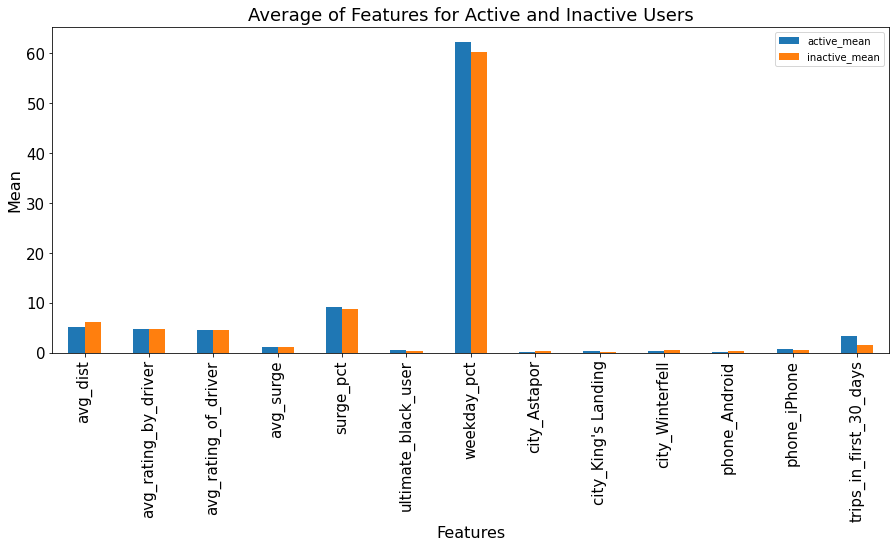

In [36]:
# visualize the statistics
stats_df[['active_mean', 'inactive_mean']].plot(kind = 'bar', figsize = (15,6), fontsize = 15)
plt.xlabel('Features',fontsize = 16)
plt.ylabel('Mean', fontsize = 16)
plt.title('Average of Features for Active and Inactive Users', fontsize = 18)

# yerr=stats_df[['active_std','inactive_std']], 

Text(0.5, 1.0, 'Std of Features for Active and Inactive Users')

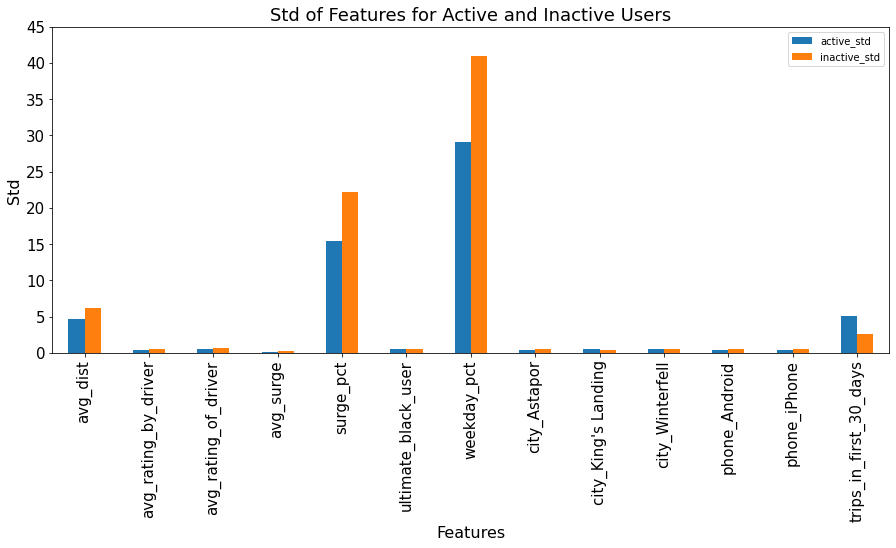

In [37]:
# visualize the statistics
stats_df[['active_std', 'inactive_std']].plot(kind = 'bar',  figsize = (15,6), fontsize = 15)
plt.xlabel('Features',fontsize = 16)
plt.ylabel('Std', fontsize = 16)
plt.ylim(0, 45)
plt.title('Std of Features for Active and Inactive Users', fontsize = 18)

# yerr=stats_df[['active_std','inactive_std']],

Based on two bar graphes above, it is clear that active and inactive users have very slight difference regarding the average value and standard deviation. And "weekday_pct" feature has a much larger scale than others, so the features might need to rescale before building the model.

#### Imputation -- Missing values

In [72]:
# Build the df including the dependent variable and all the features for modeling
df = data[feature_columns]
df['active_status'] = data[['active_status']]

In [73]:
df.isnull().sum()

avg_dist                     0
avg_rating_by_driver       201
avg_rating_of_driver      8122
avg_surge                    0
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
city_Astapor                 0
city_King's Landing          0
city_Winterfell              0
phone_Android                0
phone_iPhone                 0
trips_in_first_30_days       0
active_status                0
dtype: int64

Two features of "avg_rating_by_driver" and "avg_rating_of_driver" have missing value. I am going to use the mean value to fill the missing values.

In [74]:
df.fillna(df.mean(), inplace=True)
df.isnull().sum().sum()

0

### 3.0 Preprocessing

Let's prepare the data for the model building. Since it is a binary classification problem and I am going to use Randome Forest, the different scale of features for building the model shouldn't be problem. Let's split the data and be ready for building a binary classfication model.

In [75]:
X = df[feature_columns]
y = df['active_status']

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

### 4.0 Classification model building

This is a binary classification problem. I am going to use Random Forest to build the baseline model, and then test XGboost algorithm.

#### 4.1 Random Forest

In [83]:
rfc = RandomForestClassifier()
params = {'n_estimators': [50, 100, 150, 200, 300]}
rfc_cv = GridSearchCV(rfc, params, cv=5)
rfc_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'n_estimators': [50, 100, 150, 200, 300]})

In [84]:
print("Best Score:" + str(rfc_cv.best_score_))
print("Best Parameters: " + str(rfc_cv.best_params_))

Best Score:0.7619142857142858
Best Parameters: {'n_estimators': 200}


In [85]:
y_pred_rf = rfc_cv.predict(X_test)

In [95]:
print("The confusion matrix is:\n", confusion_matrix(y_test, y_pred_rf))

The confusion matrix is:
 [[7826 1626]
 [1937 3611]]


In [128]:
print(f"The accuracy score is {round(accuracy_score(y_test, y_pred_rf),2)}")

The accuracy score is 0.76


#### 4.2 XGboost

In [110]:
#XGBoost hyper-parameter tuning
def hyperParameterTuning(X_train, y_train):
    param_tuning = {
        'learning_rate': [0.1, 0.2, 0.5],
        'n_estimators':[150, 200],
        'max_depth':[3, 5, 8],
        'subsample':[1],
        'gamma':[0]
    }
    
    xg_model = XGBClassifier(objective = 'binary:logistic', silent=1)
    
    gsearch = GridSearchCV(estimator = xg_model,
                           param_grid = param_tuning,                        
                           scoring = 'accuracy',
                           cv = 5,
                           n_jobs = -1,
                           verbose = 1)
    
    gsearch.fit(X_train, y_train)
    
    return gsearch.best_params_, gsearch.best_score_

#####################################################################################
#Run only in the first run of the kernel.
#hyperParameterTuning(X_train, y_train)

#### Best fit model

In [111]:
xg_model = XGBClassifier(
        objective = 'binary:logistic',
        gamma = 0,
        learning_rate = 0.2,
        max_depth = 3,
        n_estimators = 200,
        subsample = 1)

%time xg_model.fit(X_train, y_train, early_stopping_rounds=5, eval_set=[(X_test, y_test)], verbose=False)

[00:15:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 406 ms


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [115]:
print("The confusion matrix is:\n", confusion_matrix(y_test, y_pred_xg))

The confusion matrix is:
 [[8232 1220]
 [1898 3650]]


In [126]:
y_train_pred = xg_model.predict(X_train)

y_pred_xg = xg_model.predict(X_test)
print(f"Accuracy score is {round(accuracy_score(y_train, y_train_pred),2)} for training data")
print(f"Accuracy score is {round(accuracy_score(y_test, y_pred_xg),2)} for testing data")

Accuracy score is 0.8 for training data
Accuracy score is 0.79 for testing data


The accuracy for training and testing data are very close. There is no overfitting for this model.

The accuracy of xgboost is 0.79 while that of Random Forest 0.76.

XGboost gives a better predictive model.

In [131]:
# Pickle the model
#pickle.dump(xg_model, open('final_xgboost_model.pickle', 'wb'))

#### 4.3 Model insight

* List the most important features of the model
* Discuss what that means for the retention

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

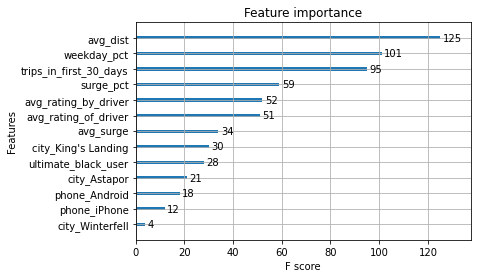

In [132]:
plot_importance(xg_model)

### 5.0 Conclusions



Grid search method was used to tune the hyperparameter for XGBoost classifier. The accuracy of testing data is 0.79, which is higher than that of random forest. The top three important features are "avg_dist", "weekday_pct", and "trips_in_first_30_days". They most heavily influence the rider retention.